In [1]:
import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.stats            import entropy

import pandas as pd
import os, glob
import re

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne   import _joint_probabilities

import seaborn as sns
import matplotlib.pyplot as plt

dat_dir = "/data/clintko/SMPK"
fhead   = "ep8cs_tsne_jsdiv"
#fhead   = "ep8cs_tsne_jsdiv"
pal = sns.light_palette("blue", as_cmap=True)

In [2]:
%matplotlib inline

In [3]:
def read_pmat(fnames):
    """stack the pmat of MPSK cal"""
    mat = [np.load(fn) for fn in fnames]
    mat = np.stack(mat, axis=2)
    return mat

def get_t1t2(mat_raw_vs_cal):
    """get the t1 + t2 from diagonal of raw vs MPSK cal"""
    diag = np.diag(mat_raw_vs_cal)
    mat_out = np.zeros((18, 18))
    for i in range(18):
        for j in range(18):
            mat_out[i, j] = diag[i] + diag[j]
    return mat_out

In [38]:
fnames = glob.glob(os.path.join(dat_dir, "ep8cs_dat_cal_prior*"))
priors = [re.findall("prior(.*).txt", x)[0] for x in fnames]
priors = np.array(priors)

In [5]:
### js div matrix: Raw x Raw
jsdiv_raw = np.load("/data/clintko/SMPK/ep8cs_tsne_jsdiv_raw.npy")

### js div matrix: MPSK calibrated x MPSK calibrated
fnames = glob.glob("/data/clintko/SMPK/ep8cs_tsne_jsdiv_cal_prior*.npy")
jsdiv_cal = read_pmat(fnames)

### js div matrix: raw vs MPSK calibrated
fnames = glob.glob("/data/clintko/SMPK/ep8cs_tsne_jsdiv_raw_cal_prior*.npy")
jsdiv_raw_cal = read_pmat(fnames)

In [7]:
print(jsdiv_raw.shape)
print(jsdiv_cal.shape)
print(jsdiv_raw_cal.shape)

(18, 18)
(18, 18, 18)
(18, 18, 18)


In [8]:
jsdiv_t1t2 = [get_t1t2(jsdiv_raw_cal[:, :, idx]) for idx in range(18)]
jsdiv_t1t2 = np.stack(jsdiv_t1t2, axis = 2)
print(jsdiv_t1t2.shape)

(18, 18, 18)


In [9]:
jsdiv_raw2 = [jsdiv_raw for _ in range(18)]
jsdiv_raw2 = np.stack(jsdiv_raw2, axis = 2)
print(jsdiv_raw2.shape)

(18, 18, 18)


# check weird values

In [17]:
[(idx, priors[idx], np.any(jsdiv_t1t2[:, :, idx] == 0), np.any(jsdiv_t1t2[:, :, idx] < 0))
 for idx in range(18)]

[(0, '05', False, False),
 (1, '06', False, False),
 (2, '07', False, False),
 (3, '08', False, False),
 (4, '09', False, False),
 (5, '10', False, False),
 (6, '11', False, False),
 (7, '12', False, False),
 (8, '13', False, False),
 (9, '14', False, False),
 (10, '15', False, False),
 (11, '20', True, True),
 (12, '25', False, True),
 (13, '30', False, True),
 (14, '35', False, True),
 (15, '40', False, True),
 (16, '45', False, True),
 (17, '50', True, True)]

In [11]:
mat = jsdiv_raw_cal[:, :, 11]
idx = np.where(mat <= 0)
print(np.stack(idx))
print(mat[idx])

[[ 1  3  4  5  7  9 14 17]
 [ 1  3  4  5  7  9 14 17]]
[-6.95540929e-19 -2.79457798e-18 -3.08563656e-18 -4.40493754e-18
 -4.89974881e-18 -3.49747444e-18  0.00000000e+00 -3.03945620e-18]


In [12]:
import pyximport
pyximport.install()
import jsdiv

In [13]:
prior = priors[11]
print(prior)

20


In [14]:
fhead   = "ep8cs_tsne_similarity"
prior   = priors[11]
p_raw   = np.load(os.path.join(dat_dir, fhead + "_raw.npy"))
p_cal20 = np.load(os.path.join(dat_dir, fhead + "_cal_prior" + prior + ".npy"))
DIM = 18

In [15]:
print(p_raw.shape)
print(p_cal20.shape)

(49995000, 18)
(49995000, 18)


In [26]:
p1 = p_raw[:, 1]
p2 = p_cal20[:, 1]
print(jsdiv.entropy_cy(p1, p2) * 2)
print(jsdiv.entropy_cy(p2, p1) * 2)
print(jsdiv.jsdiv_cy(p1, p2)   * 2)

-5.293723368368323e-18
3.902641510392528e-18
-6.955409289878975e-19


In [27]:
# using scipy
print(entropy(p1, p2))
print(entropy(p2, p1))
print(0.5 * (entropy(p1, p2) + entropy(p2, p1)))

-5.293723255179614e-18
3.9026414269503555e-18
-6.955409141146293e-19


In [20]:
# double check in the matrix
jsdiv_raw_cal[:2, :2, 11]

array([[ 4.06257511e-18,  2.29280733e+01],
       [ 2.29280733e+01, -6.95540929e-19]])

"The Kullback–Leibler divergence is always non-negative" from [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

# calculate the metric

In [34]:
idx = np.array([np.all(jsdiv_t1t2[:, :, idx] != 0) for idx in range(18)])
print(idx)

[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False]


In [55]:
priors[11]

'20'

In [53]:
p    = priors[idx].astype(int)
diff = jsdiv_cal[:, :, idx] - jsdiv_raw2[:, :, idx]
metric = diff / jsdiv_t1t2[:, :, idx]
print(diff.shape)
print(metric.shape)

(18, 18, 16)
(18, 18, 16)


In [66]:
priors.astype(int)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45,
       50])

In [80]:
np.arange(20)[5, 6., 8, 10, 12, 14, 15, 20, 25, 30, 35, 40, 45, 50]

array([ 5,  7,  9, 11, 13, 15, 17, 19])

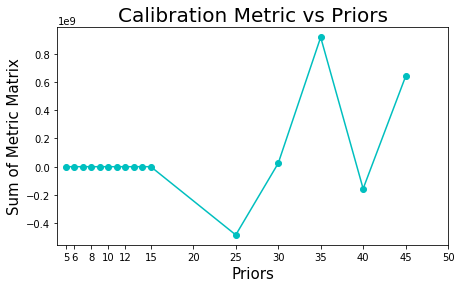

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
val = metric.sum(axis = 0).sum(axis = 0)

#ax.plot(p[:11], val[:11], "co-")
#ax.plot(p[11:], val[11:], "co-")
ax.plot(p, val, "co-")

ax.set_xlim((4, 50))
ax.set_xticks([5, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50])

ax.set_title("Calibration Metric vs Priors",      size = 20)
ax.set_xlabel("Priors",               size = 15)
ax.set_ylabel("Sum of Metric Matrix", size = 15)

plt.savefig("Calibration_Metric_vs_Priors.png", dpi=300)
pass

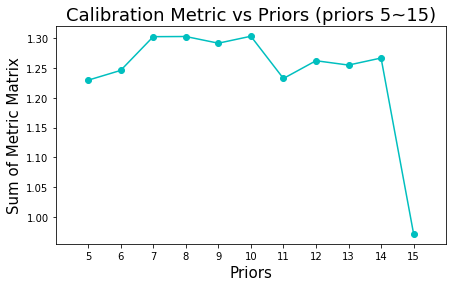

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
val = metric.sum(axis = 0).sum(axis = 0)

ax.plot(p[:11], val[:11], "co-")

ax.set_xlim((4, 16))
ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

ax.set_title("Calibration Metric vs Priors (priors 5~15)", size = 18)
ax.set_xlabel("Priors",               size = 15)
ax.set_ylabel("Sum of Metric Matrix", size = 15)

plt.savefig("Calibration_Metric_vs_Priors_5_to_15.png", dpi=300)
pass

In [29]:
p_cal

array([[ 0.        , 23.01933332, 23.01575644, 23.01567403, 23.0168688 ,
        23.01440715, 23.00949286, 22.96944427, 23.01425728, 23.00156701,
        23.00918295, 23.004269  , 23.001657  , 23.00224821, 23.0094571 ,
        23.00998239, 23.01115464, 23.01371745],
       [23.01933332,  0.        , 23.02957606, 23.03758413, 23.03451449,
        23.04112615, 23.02954896, 22.99545905, 23.02217236, 23.01455802,
        23.03363833, 23.01665925, 23.02614139, 23.02271896, 23.03131286,
        23.02653449, 23.02601924, 23.0341355 ],
       [23.01575644, 23.02957606,  0.        , 23.02813849, 23.02316626,
        23.03631908, 23.00235365, 22.98271118, 23.01996319, 23.01290599,
        23.03541862, 23.00877477, 23.01624964, 23.02741241, 23.01040666,
        23.02165185, 23.02735133, 23.04035433],
       [23.01567403, 23.03758413, 23.02813849,  0.        , 23.01994369,
        23.03078841, 23.02086479, 22.9830994 , 23.0227741 , 23.00778366,
        23.02448934, 23.01511932, 23.01641379, 23.017

In [24]:
mat = np.load('/data/clintko/SMPK/ep8cs_tsne_jsdiv_cal_prior06.npy')

In [25]:
mat

array([[ 0.        , 23.00654379, 22.99312659, 23.00688553, 23.01194309,
        23.02165173, 23.00107203, 22.97744172, 23.00744692, 22.99314846,
        23.01434392, 22.98551095, 22.99105483, 23.00230313, 23.01061021,
        23.0007607 , 23.00808728, 23.01366451],
       [23.00654379,  0.        , 23.01188128, 23.03185629, 23.03299827,
        23.04017079, 23.02569932, 22.97767635, 23.02471835, 23.01239105,
        23.03403788, 23.00509842, 23.01107484, 23.0321615 , 23.02372115,
        23.02349712, 23.00894125, 23.03707326],
       [22.99312659, 23.01188128,  0.        , 23.0173227 , 23.02020169,
        23.01838862, 22.99654049, 22.97736912, 23.00531704, 22.98914106,
        23.00988335, 22.98137351, 22.99403977, 23.00800344, 23.00469218,
        23.00446879, 23.00428964, 23.00975807],
       [23.00688553, 23.03185629, 23.0173227 ,  0.        , 23.03438869,
        23.03191001, 23.02809014, 22.98894313, 23.01751284, 22.99878139,
        23.03002585, 23.00018372, 23.01031492, 23.024